## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
df = pd.read_csv('/data/Data_Entry_2017.csv')
image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', df.shape[0])
df['ImagePath'] = df['Image Index'].map(image_paths.get)
df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,ImagePath
59150,00014628_002.png,Atelectasis|Infiltration,2,14628,35,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014628_002.png
36768,00009689_004.png,No Finding,4,9689,54,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00009689_004.png
42517,00010938_003.png,No Finding,3,10938,33,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010938_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')))))
labels = [l for l in labels if len(l) > 0]

for l in labels:
    df[l] = df['Finding Labels'].map(lambda x: 1. if l in x else 0.)

df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
df['Pneumonia_Class'] = df['Pneumonia'].map(lambda x: 'Positive' if x==1.0 else 'Negative')
df.head(4)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_Class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative


## Create your training and testing data:

In [5]:
def create_splits(data):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, valid_data = train_test_split(data, test_size=0.2, stratify = data['Pneumonia_Class'])
    
    # Ensuring training dataset have equal number of disease and non-disease classes
    all_disease_rows = train_data[train_data['Pneumonia_Class']=='Positive'].index.tolist()
    all_non_disease_rows = train_data[train_data['Pneumonia_Class']=='Negative'].index.tolist()
    
    sel_non_disease_rows = sample(all_non_disease_rows, len(all_disease_rows))
    train_data = train_data.loc[sel_non_disease_rows + all_disease_rows]
    
    # Ensuring validation set has 80% and 20% of disease and non-disease cases
    all_disease_rows = valid_data[valid_data['Pneumonia_Class']=='Positive'].index.tolist()
    all_non_disease_rows = valid_data[valid_data['Pneumonia_Class']=='Negative'].index.tolist()
    
    sel_non_disease_rows = sample(all_non_disease_rows, 4*len(all_disease_rows))
    valid_data = valid_data.loc[all_disease_rows + sel_non_disease_rows]
    
    # return the dataset
    return train_data, valid_data

In [6]:
# Total records in the dataframe
len(df)

112120

In [7]:
# Disease prevalence
df[labels].sum()/len(df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

In [8]:
train_df, valid_df = create_splits(df)

print('There are {} rows in the training set & {} rows in validation sets.'.format(len(train_df), len(valid_df)))


There are 2290 rows in the training set & 1430 rows in validation sets.


In [9]:
# Checking disease and non-diseases cases in training set
train_df['Pneumonia_Class'].value_counts()

Negative    1145
Positive    1145
Name: Pneumonia_Class, dtype: int64

It can be seen that we have equal number of negative and positive cases in the training data.

In [10]:
# Checking validation set has same prevalnce of disease as full dataset
print('Validation set has {}% disease classes.'.format(len(valid_df[valid_df['Pneumonia_Class']=='Positive'])/len(valid_df) * 100))
print('Validation set has {}% non-disease classes.'.format(len(valid_df[valid_df['Pneumonia_Class']=='Negative'])/len(valid_df) * 100))


Validation set has 20.0% disease classes.
Validation set has 80.0% non-disease classes.


This is exactly was I wanted to achieve. Great.


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
IMG_SIZE = (224,224)

In [12]:
def image_augmentation(ds_type):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if ds_type=='train':
        idg = ImageDataGenerator(rescale=1. / 255.,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    height_shift_range=0.1,
                                    width_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    rotation_range=20)
    elif ds_type=='valid':
        
        idg = ImageDataGenerator(rescale= 1. /255.)
    
    
    return idg


def data_gen(ds_type, df, x_col, y_col, class_mode, target_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    if ds_type=='train':
        idg = image_augmentation('train')
    
        gen = idg.flow_from_dataframe(dataframe=df,
                                                  directory=None,
                                                  x_col = x_col,
                                                  y_col = y_col,
                                                  class_mode = class_mode,
                                                  target_size = target_size,
                                                  batch_size = batch_size
                                                 )
    elif ds_type=='valid':
        
        idg = image_augmentation('valid')
        
        gen = idg.flow_from_dataframe(dataframe=df,
                                                  directory=None,
                                                  x_col = x_col,
                                                  y_col = y_col,
                                                  class_mode = class_mode,
                                                  target_size = target_size,
                                                  batch_size = batch_size
                                                 )
                                            

    return gen


In [13]:
train_gen = data_gen ('train', train_df, 'ImagePath', 'Pneumonia_Class', 'binary', IMG_SIZE, 32)
valid_gen = data_gen ('valid', valid_df, 'ImagePath', 'Pneumonia_Class', 'binary', IMG_SIZE, 32)


Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valid_x, valid_y = valid_gen.next()

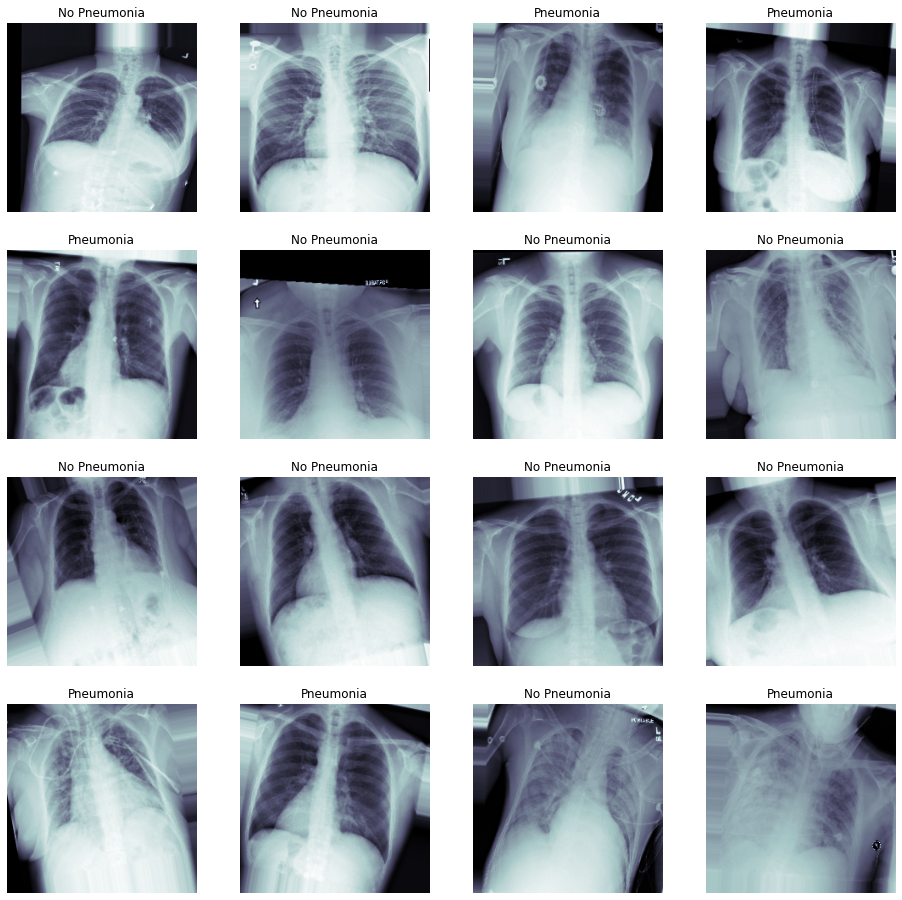

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model(layer_of_interest):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    pretrained_full_vgg_classifier = VGG16(include_top=True, weights = 'imagenet')
    transfer_layer = pretrained_full_vgg_classifier.get_layer(layer_of_interest)
    pretrained_headless_vgg_classifier = Model(inputs = pretrained_full_vgg_classifier.input, 
                                               outputs = transfer_layer.output)
    
    for layer in pretrained_headless_vgg_classifier.layers: layer_trainable = False
        
    return pretrained_headless_vgg_classifier


In [17]:
def learner(vgg_classifier, dropout, lr):
    
    # Creating the classifier
    pneumonia_classifier = Sequential()
    
    # Copying headless VGG16 to the classifier
    pneumonia_classifier.add(vgg_classifier)

    # Flattening the output from last convolution layer
    pneumonia_classifier.add(Flatten())
    
    # Adding dropout for regularization
    pneumonia_classifier.add(Dropout(dropout))
    
    # Adding fully connected layer
    pneumonia_classifier.add(Dense(1024, activation = 'relu'))
    
    # Adding dropout for regularization
    pneumonia_classifier.add(Dropout(dropout))    
    
    # Adding fully connected layer
    pneumonia_classifier.add(Dense(512, activation = 'relu'))

    # Adding dropout for regularization
    pneumonia_classifier.add(Dropout(dropout))
    
    # Adding fully connected layer
    pneumonia_classifier.add(Dense(256, activation = 'relu'))

    # Adding last sigmoid layer
    pneumonia_classifier.add(Dense(1, activation = 'sigmoid'))
    
    # Configuring learning rate for Adam optimizer 
    optimizer = Adam(lr=lr)
    
    # Specifying loss function
    loss='binary_crossentropy'
    
    # Specifyiing metrics to be printed during training proess
    metrics='binary_accuracy'
    
    # Finally compiling the classifier
    pneumonia_classifier.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
    
    return pneumonia_classifier



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="pneumonia_classifier.best.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss',
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
## train your model

# Todo

vgg_classifier = load_pretrained_model('block5_pool')
model = learner(vgg_classifier, 0.5, 1e-4)

training_log = model.fit_generator(train_gen,
                                   validation_data = (valid_x, valid_y),
                                   epochs = 10, 
                                   callbacks = callbacks_list)

553467904/553467096 [==============================] - 6s 0us/step
Epoch 1/10
72/72 [==============================] - 103s 1s/step - loss: 0.7190 - binary_accuracy: 0.5144 - val_loss: 0.6880 - val_binary_accuracy: 0.7188

Epoch 00001: val_loss improved from inf to 0.68797, saving model to pneumonia_classifier.best.hdf5
Epoch 2/10
72/72 [==============================] - 67s 937ms/step - loss: 0.6933 - binary_accuracy: 0.4974 - val_loss: 0.6941 - val_binary_accuracy: 0.2812

Epoch 00002: val_loss did not improve from 0.68797
Epoch 3/10
72/72 [==============================] - 79s 1s/step - loss: 0.6932 - binary_accuracy: 0.5009 - val_loss: 0.6951 - val_binary_accuracy: 0.2812

Epoch 00003: val_loss did not improve from 0.68797
Epoch 4/10
72/72 [==============================] - 86s 1s/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6940 - val_binary_accuracy: 0.2812

Epoch 00004: val_loss did not improve from 0.68797
Epoch 5/10
72/72 [==============================] - 77s 1

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valid_x, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 14ms/step


In [21]:
pred_Y

array([[0.4950484 ],
       [0.49219146],
       [0.49672645],
       [0.49041033],
       [0.49772942],
       [0.49366194],
       [0.49752122],
       [0.4939367 ],
       [0.49378818],
       [0.49302295],
       [0.49722573],
       [0.49672097],
       [0.495232  ],
       [0.49434263],
       [0.4987926 ],
       [0.49652928],
       [0.49600187],
       [0.4963214 ],
       [0.49040884],
       [0.49950185],
       [0.48821467],
       [0.49381948],
       [0.4961692 ],
       [0.4957022 ],
       [0.4955842 ],
       [0.49695346],
       [0.49583524],
       [0.49661782],
       [0.4940781 ],
       [0.49465963],
       [0.49497917],
       [0.49293742]], dtype=float32)

In [32]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

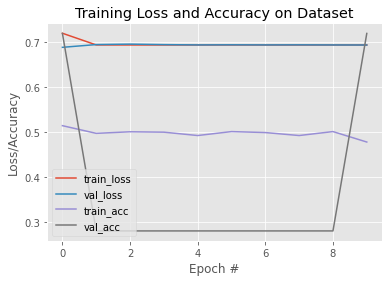

In [33]:
plot_history(training_log)

In [36]:
model = learner(vgg_classifier, 0.3, 1e-4)

training_log = model.fit_generator(train_gen,
                                   validation_data = (valid_x, valid_y),
                                   epochs = 10, 
                                   callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 67s 937ms/step - loss: 0.7021 - binary_accuracy: 0.5140 - val_loss: 0.6937 - val_binary_accuracy: 0.3438

Epoch 00001: val_loss did not improve from 0.68797
Epoch 2/10
72/72 [==============================] - 65s 907ms/step - loss: 0.6949 - binary_accuracy: 0.4991 - val_loss: 0.6865 - val_binary_accuracy: 0.7188

Epoch 00002: val_loss improved from 0.68797 to 0.68648, saving model to pneumonia_classifier.best.hdf5
Epoch 3/10
72/72 [==============================] - 65s 903ms/step - loss: 0.6940 - binary_accuracy: 0.5022 - val_loss: 0.7057 - val_binary_accuracy: 0.2812

Epoch 00003: val_loss did not improve from 0.68648
Epoch 4/10
72/72 [==============================] - 64s 884ms/step - loss: 0.6934 - binary_accuracy: 0.4939 - val_loss: 0.6945 - val_binary_accuracy: 0.2812

Epoch 00004: val_loss did not improve from 0.68648
Epoch 5/10
72/72 [==============================] - 63s 881ms/step - loss: 0.6932 - binary_accuracy: 0.5026 - va

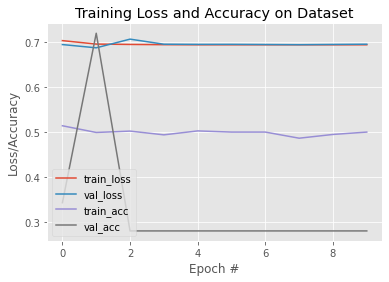

In [37]:
plot_history(training_log)

In [38]:
model = learner(vgg_classifier, 0.5, 1e-6)

training_log = model.fit_generator(train_gen,
                                   validation_data = (valid_x, valid_y),
                                   epochs = 10, 
                                   callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 65s 907ms/step - loss: 0.6931 - binary_accuracy: 0.4983 - val_loss: 0.6931 - val_binary_accuracy: 0.2812

Epoch 00001: val_loss did not improve from 0.68648
Epoch 2/10
72/72 [==============================] - 63s 880ms/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.2812

Epoch 00002: val_loss did not improve from 0.68648
Epoch 3/10
72/72 [==============================] - 63s 880ms/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.2812

Epoch 00003: val_loss did not improve from 0.68648
Epoch 4/10
72/72 [==============================] - 63s 878ms/step - loss: 0.6931 - binary_accuracy: 0.4825 - val_loss: 0.6931 - val_binary_accuracy: 0.7188

Epoch 00004: val_loss did not improve from 0.68648
Epoch 5/10
72/72 [==============================] - 63s 879ms/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.2812

Epoch 

In [19]:
vgg_classifier = load_pretrained_model('block5_pool')
model = learner(vgg_classifier, 0.5, 1e-6)
model.load_weights(weight_path)
valid_gen.reset()

pred_Y = model.predict(valid_gen, verbose = True)

45/45 [==============================] - 29s 653ms/step


In [20]:
pred_Y.shape

(1430, 1)

In [27]:
pred_Y = np.array(pred_Y).flatten().tolist()
preds_df=pd.DataFrame({'Actual':valid_gen.labels,'Output': pd.Series(pred_Y)})
preds_df.sort_values('Actual',ascending=False).head(10)

,Actual,Output
0,1,0.491641
189,1,0.492716
195,1,0.493321
194,1,0.492210
193,1,0.492089
192,1,0.493532
191,1,0.492070
190,1,0.492004
188,1,0.492397
197,1,0.493468


In [32]:
def plot_precision_recall_curve(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo

    precision, recall, threshold = precision_recall_curve(t_y, p_y, pos_label = 1)
    threshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.show()
    
    return precision, recall, threshold

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def plot_roc(t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label = 1)
#    np.append(thresholds, 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=.8)
    plt.show()
    
    return fpr, tpr, thresholds

# def ...
# Todo

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.show()
    
    return precision, recall, f1, threshold

def plot_auc(t_y, p_y):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.style.use('ggplot')
    fpr, tpr, thresholds = plot_roc(t_y, p_y)
    res = auc(fpr, tpr)
    print("AUC-ROC is: " + str(res))
    return fpr, tpr, thresholds, res
    
#Also consider plotting the history of your model training:

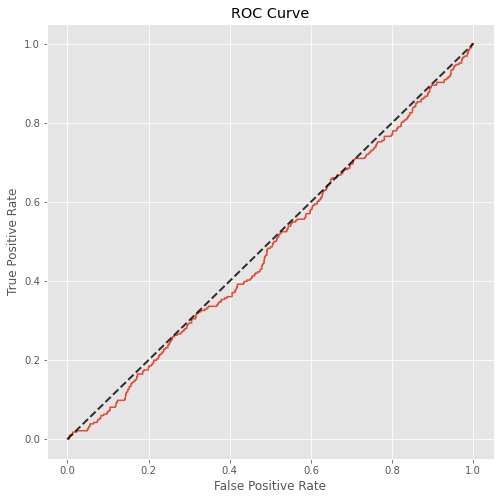

AUC-ROC is: 0.4820299892415277


In [33]:
## plot figures

fpr, tpr, thresholds_ROC, AUC = plot_auc(preds_df['Actual'],preds_df['Output'])

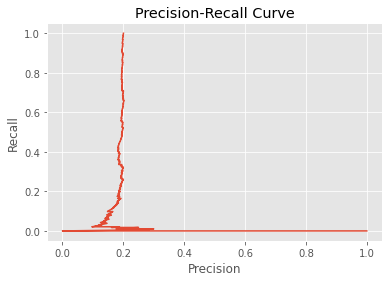

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


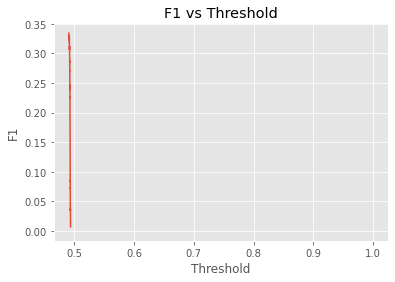

In [34]:
precision, recall, f1, thresholds_f1 = plot_f1(preds_df['Actual'],predictions_df['Output'])

In [35]:
recall_df = pd.DataFrame({"Precision":precision, "Threshold":thresholds_f1, "Recall":recall, "F1":f1})

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [36]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

def find_ROC_thresh(fpr,tpr,thresh):
    dist1=0
    dist2=0
    tprmax = 0
    for i in range(len(fpr)):
        dist2 = tpr[i] - fpr[i]
        if dist2 > dist1:
            dist1 = dist2
            tprmax=tpr[i]
        else:
            continue
    df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresh})
    threshmax = df['threshold'][df['tpr']==tprmax].iloc[-1]
    return threshmax

def find_F1_thresh(f1,thresh):
    df = pd.DataFrame({'f1':f1,'threshold':thresh})
    threshmax = df['threshold'][df['f1']==df['f1'].max()].iloc[-1]
    return threshmax

In [37]:
thresh_ROC = find_ROC_thresh(fpr,tpr, thresholds_ROC)
print("thresh_ROC is " + str(thresh_ROC))

thresh_ROC is 0.49241647124290466


In [38]:
thresh_F1 = find_F1_thresh(f1, thresholds_f1)
print("thresh_F1 is " + str(thresh_F1))

thresh_F1 is 0.49109145998954773


ValueError: not enough values to unpack (expected 3, got 2)

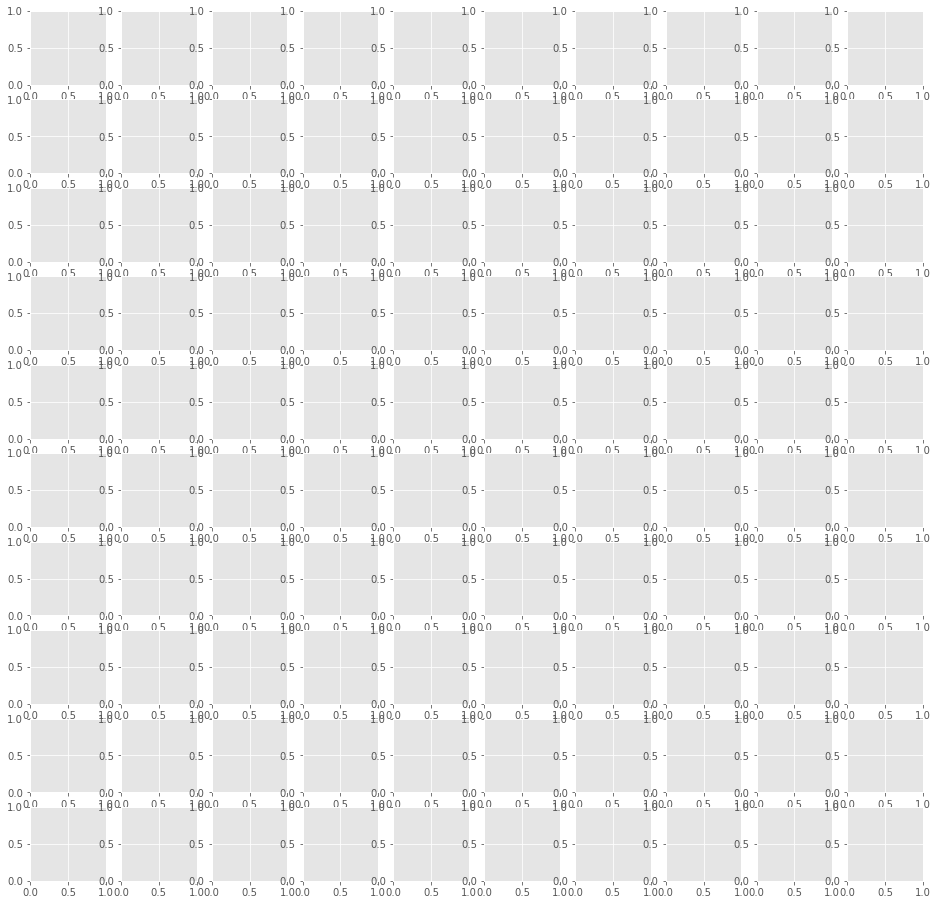

In [41]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valid_x[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [44]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("pneumonia_classifier_arch.json", "w") as json_file:
    json_file.write(model_json)